# Predicción del progreso de la diabetes

En este laboratorio debe construir un modelo predictivo de regresión para predecir el progreso de la diabetes en pacientes usando scikit-learn. La base de datos contine un total de 442 pacientes y 10 variables de entrada que pueden ser utilizadas para predecir el progreso de la diabetes (columna target en el dataset). Las variables de entrada son:

* age

* sex

* bmi

* bp

* s1

* s2

* s3

* s4

* s5

* s6

El modelo debe ser estimado usando la información disponible en el archivo train_dataset.csv y evaluado usando el archivo test_dataset.csv. El modelo obtenido debe ser salvado en el archivo model.pkl.

### Exploración de los datos en train

In [50]:
import pandas as pd
train_dataset = pd.read_csv('train_dataset.csv') 
print('Nulos:', train_dataset.isnull().sum().sum())
print('Duplicados:', train_dataset.duplicated().sum())

Nulos: 0
Duplicados: 0


In [51]:
train_dataset.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,-0.000330,-0.003922,0.002957,-0.000764,0.000377,0.001124,0.000368,-0.001172,-0.000469,0.002247,153.262136
std,0.047257,0.047229,0.047520,0.047536,0.047779,0.047496,0.046248,0.044466,0.044972,0.045749,75.124696
min,-0.107226,-0.044642,-0.090275,-0.112399,-0.126781,-0.106845,-0.098625,-0.076395,-0.126097,-0.129483,25.000000
25%,-0.034575,-0.044642,-0.032073,-0.036656,-0.034592,-0.030124,-0.032356,-0.039493,-0.031988,-0.025930,89.000000
50%,0.005383,-0.044642,-0.002973,-0.005670,-0.004321,-0.003193,-0.006584,-0.002592,-0.002398,0.003064,142.000000
75%,0.038076,0.050680,0.036907,0.035644,0.030078,0.031880,0.026550,0.034309,0.032432,0.027917,210.000000
max,0.110727,0.050680,0.170555,0.132044,0.153914,0.155887,0.177497,0.155345,0.133397,0.135612,336.000000


<Axes: title={'center': 'Pearson Correlation of Features'}>

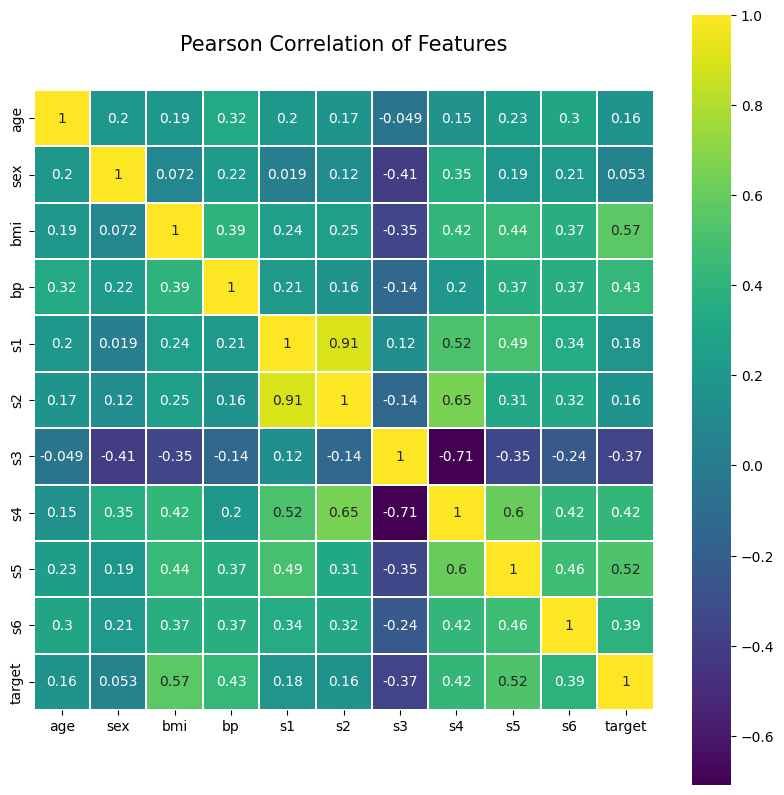

In [52]:
import matplotlib.pyplot as plt
import seaborn as sb

colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(train_dataset.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, )


Después de analizar los datos, se evidencia que las posibles variables predictoras están en longitud unitaria. Por su parte, la columna target varía entre 25 y 336, siendo valores enteros.

### Desarrollo

Se cargan los datos que ya están divididos en train y test

In [53]:
def load_data():
    import pandas as pd
    train_dataset = pd.read_csv('train_dataset.csv')
    y_train = train_dataset.pop('target')
    x_train = train_dataset.copy()

    test_dataset = pd.read_csv('test_dataset.csv')
    y_test = test_dataset.pop('target')
    x_test = test_dataset.copy()

    return x_train, y_train, x_test, y_test

Para estos datos no se necesita aplicar un transformer. Sin embargo, utilizaremos un pipeline para primero seleccionar las k mejores características para hacer el modelo de regresión y luego se hace con esos k parámetros mejores la estimación del modelo

In [54]:
def make_pipeline(estimator):

    from sklearn.feature_selection import SelectKBest, f_regression
    from sklearn.pipeline import Pipeline

    selectkbest = SelectKBest(score_func=f_regression)

    pipeline = Pipeline(
        steps=[
            ("selectkbest", selectkbest),
            ("estimator", estimator),
        ],
        verbose=False,
    )

    return pipeline

Se crea el grid_search, al que se le pasa el estimador en base al cuál se probará una malla de hiperparámetros distintos, hasta quedarse con el que tenga menor error medio absoluto 

In [55]:
def make_grid_search(estimator, param_grid, cv=5):

    from sklearn.model_selection import GridSearchCV

    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=cv,
        scoring='neg_mean_absolute_error',
    )

    return grid_search

In [56]:
def save_estimator(estimator):

    import pickle

    with open("model.pkl", "wb") as file:
        pickle.dump(estimator, file)

In [57]:
def load_estimator():

    import os
    import pickle

    if not os.path.exists("model.pkl"):
        return None
    with open("model.pkl", "rb") as file:
        estimator = pickle.load(file)

    return estimator

Se entrena el modelo de regresión lineal en base a los parámetros encontrados en el pipeline y se compara con el que está guardado

In [58]:
def train_linear_regression():

    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_absolute_error
    

    x_train, y_train, x_test, y_test = load_data()

    pipeline = make_pipeline(
        estimator=LinearRegression(),
    )

    estimator = make_grid_search(
        estimator=pipeline,
        param_grid={
            "selectkbest__k": range(1, len(x_train.columns) + 1),
        },
    )

    estimator.fit(x_train, y_train)

    best_estimator = load_estimator()

    if best_estimator is not None:

        saved_mae = mean_absolute_error(
            y_true = y_test, y_pred=best_estimator.predict(x_test)
        )

        current_mae = mean_absolute_error(
            y_true = y_test, y_pred=estimator.predict(x_test)
        )

        if saved_mae < current_mae:
            estimator = best_estimator

    save_estimator(estimator)


train_linear_regression()

In [59]:
def eval_metrics(y_true, y_pred):

    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return mse, mae, r2

In [60]:
def report(estimator, mse, mae, r2):

    print(estimator, ":", sep="")
    select_k_best = estimator.named_steps["selectkbest"]
    print(f"El valor de k seleccionado es: {select_k_best.k}")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"   R2: {r2}")

Se comprueba el funcionamiento del estimador con el MSE, MAE y R2 con los datos de test

In [63]:
def check_estimator():

    x_train, y_train, x_test, y_test = load_data()

    estimator = load_estimator()

    mse, mae, r2 = eval_metrics(
        y_test,
        estimator.predict(x_test),
    )

    report(estimator.best_estimator_, mse, mae, r2)


check_estimator()


Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x00000188E432D260>)),
                ('estimator', LinearRegression())]):
El valor de k seleccionado es: 10
  MSE: 2855.8184535056253
  MAE: 43.143476218056364
   R2: 0.5690847834753974


Se seleccionaron todas las características para el entrenamiento del modelo